In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
import numpy as onp
import jax.numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as t
from ipywidgets import interact
from jax import grad
from jax.scipy.optimize import minimize
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax.scipy.linalg import cholesky, cho_factor, cho_solve
from jax.scipy.optimize import minimize
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box
import pandas as pd

In [2]:
PCANet = pd.read_csv("data/PCA_NS.csv", header = None).to_numpy()
DeepONet = pd.read_csv("data/DeepONet_NS.csv", header = None).to_numpy()
Para = pd.read_csv("data/PARA_NS.csv", header = None).to_numpy()
FNO = pd.read_csv("data/FNO_NS.csv", header = None).to_numpy()

In [3]:
#The columns = [Nexamples, network width, Train, Test]

In [4]:
Inputs = onp.load('data/Advection_inputs.npy')
Outputs = onp.load('data/Advection_outputs.npy')

GP regression

In [5]:
def sqeuclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum( (x - y) ** 2)
dists = jit(vmap(vmap(sqeuclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))

def euclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum( (x - y) ** 2))
sqdists = jit(vmap(vmap(euclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))


@jit
def matern(v1, v2, sigma = 50):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = sqdists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def exp(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    return np.exp(-d/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def iq(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)
    return 1/np.sqrt(d+sigma)

In [6]:
Ntrain = 20000

In [22]:
res = np.linalg.svd(Ytr)

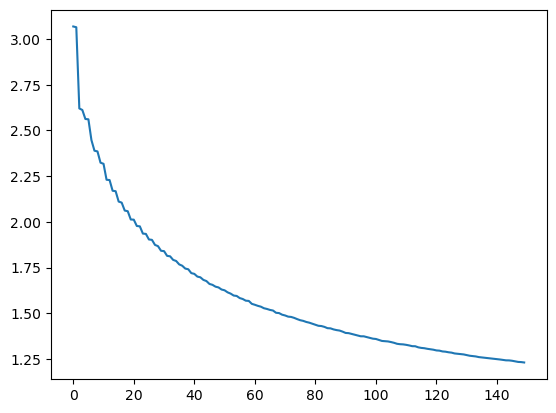

In [23]:
plt.plot(np.log10(res[1]))

In [13]:
Xtr.shape

(20000, 150)

In [10]:
Xtr = Inputs.T[:Ntrain]
pca_inp = PCA(n_components=150)
Xtr = pca_inp.fit_transform(Xtr)
Xtest = pca_inp.transform(Inputs.T[20000:])

Ytr = Outputs.T[:Ntrain]
pca_out = PCA(n_components=150)
Ytr = pca_out.fit_transform(Ytr)
Ytest = pca_out.transform(Outputs.T[20000:])

In [11]:
for kernel in [matern]:
    for s in [50]:
        for nugget in [1e-12]:
                k = kernel
                Kxx = k(Xtr, Xtr, s)
                nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
                L = cho_factor(nuggeted_matrix)
                result = cho_solve(L, Ytr)
                Train_pred = Kxx@result #train predictions
                K_te_tr = k(Xtest, Xtr,s)
                Test_pred = K_te_tr@result #test predictions

                aux1 = np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))
                aux2 = np.mean(np.linalg.norm(Train_pred-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
                aux3 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1))
                aux4 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1)/np.linalg.norm(Ytest, axis = 1))

                true_pred = pca_out.inverse_transform(Test_pred)
                true_ytest = Outputs.T[20000:]

                aux5 = np.mean(np.linalg.norm(true_ytest-true_pred, axis = 1))
                aux6 = np.mean(np.linalg.norm(true_ytest-true_pred, axis = 1)/np.linalg.norm(Ytest, axis = 1))

                print(s, nugget)
                print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (PCA space, abs): {2} \n Test error (PCA space, rel): {3} \n Test error (Real space, abs): {4} \n Test error (Real space, rel): {5} ".format(aux1, aux2, aux3, aux4, aux5, aux6))
                print('---')

50 1e-12

 Train error (abs): 0.5418360071380336 
 Train error (rel): 0.03836745019438219 
 Test error (PCA space, abs): 2.0049261852702154 
 Test error (PCA space, rel): 0.14206269846077207 
 Test error (Real space, abs): 2.203369611578916 
 Test error (Real space, rel): 0.1561199706030817 
---
